# Рекомендация тарифов для клиентов телеком оператора

**Задача проекта:** на основании данных о поведении клиентов построить модель с максимально большим значением *accuracy* для задачи классификации, которая предложит подходящий тариф (smart или ultra).

## Загрузка и подготовка данных

In [1]:
# загружем библиотеки и подготавливаем рабочее пространство

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
# загружаем файл,
# читаем первые 5 строк,
# выводим общую информацию о файле
data = pd.read_csv('/datasets/users_behavior.csv')
display(data.head(5))
display(data.info())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

In [3]:
# проверяем наличие пропусков
print('Количество пропущенных значений:\n', data.isnull().sum())

Количество пропущенных значений:
 calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


In [4]:
# проверяем наличие дубликатов
print('Количество дубликатов:\n', data.duplicated().sum())

Количество дубликатов:
 0


**Выводы по данным:**
* таблица содержит 3214 записей и 5 колонок
* названия колонок и данные записаны в ожидаемом формате
* таблица не содержит пропусков
* таблица не содержит дубликатов

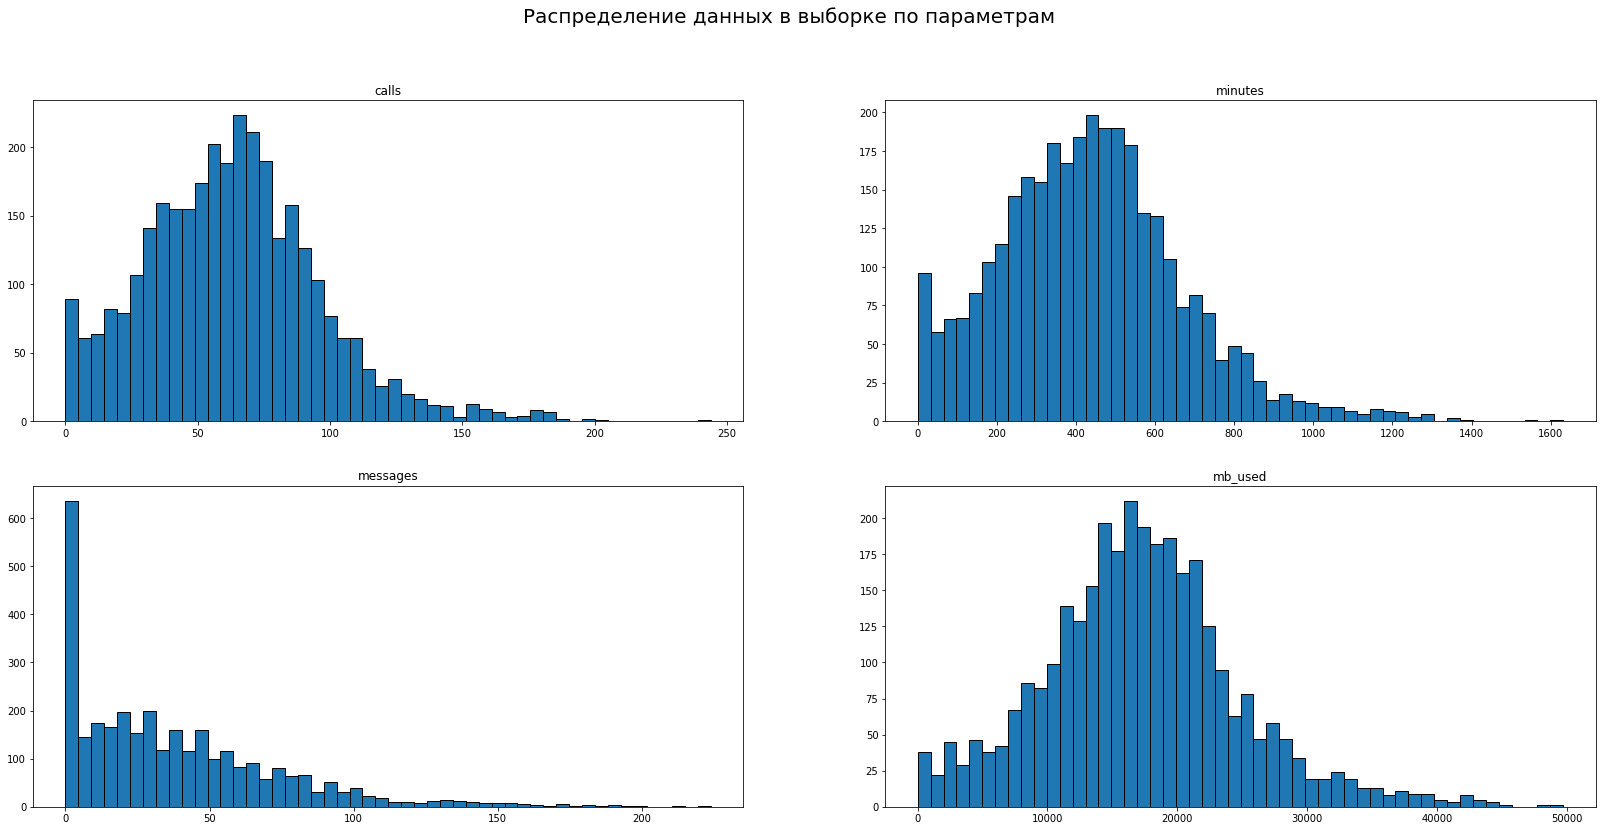

In [5]:
# проверяем распределение данных в выборке по параметрам,
# строим гистограммы
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(28, 13)
fig.suptitle('Распределение данных в выборке по параметрам', fontsize=20)
axes = axes.ravel()
i = 0
columns = ['calls', 'minutes', 'messages', 'mb_used']
for column in columns:
    axes[i].hist(data[column], edgecolor = 'black', bins=50)
    axes[i].set(title = column)
    
    i+=1

fig.show()

**Выводы по графикам:**
* данные имеют не нормальное распределение
* во всех параметрах имеются выбросы
* данные имеют разный масштаб

Доля тарифа ultra: 0.30647168637212197


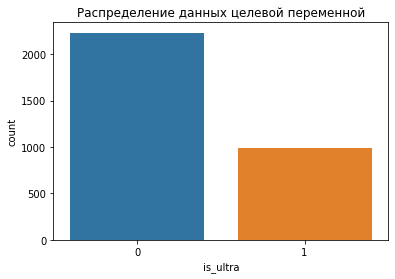

In [6]:
# проверяем распределение данных целевой переменной - баланс классов
sns.countplot(data=data, x='is_ultra')
plt.title('Распределение данных целевой переменной', fontsize=12);
print('Доля тарифа ultra:', data.is_ultra.mean())

**Выводы по графику:**
* Доля объектов, относящихся к тарифу ultra, составляет 30,65%

In [7]:
# выводим статистические данные по параметрам
# с разбивкой по целевой перменной
data_u_stat = data[data['is_ultra'] == 0].describe().reset_index()
data_s_stat = data[data['is_ultra'] == 1].describe().reset_index()
data_stat = data_u_stat.merge(data_s_stat, on='index', suffixes=('_smart', '_ultra'))\
.reindex(columns= ['index', 'calls_smart', 'calls_ultra', 'minutes_smart', 'minutes_ultra', 'messages_smart', 'messages_ultra'\
                   , 'mb_used_smart', 'mb_used_ultra'])
display(data_stat.style.set_properties(**{'background-color': 'lightsteelblue'}\
                                       , subset=['calls_ultra', 'minutes_ultra', 'messages_ultra', 'mb_used_ultra']))

,index,calls_smart,calls_ultra,minutes_smart,minutes_ultra,messages_smart,messages_ultra,mb_used_smart,mb_used_ultra
0,count,2229.000000,985.000000,2229.000000,985.000000,2229.000000,985.000000,2229.000000,985.000000
1,mean,58.463437,73.392893,405.942952,511.224569,33.384029,49.363452,16208.466949,19468.823228
2,std,25.939858,43.916853,184.512604,308.031100,28.227876,47.804457,5870.498853,10087.178654
3,min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,40.000000,41.000000,274.230000,276.030000,10.000000,6.000000,12643.050000,11770.280000
5,50%,60.000000,74.000000,410.560000,502.550000,28.000000,38.000000,16506.930000,19308.010000
6,75%,76.000000,104.000000,529.510000,730.050000,51.000000,79.000000,20043.060000,26837.720000
7,max,198.000000,244.000000,1390.220000,1632.060000,143.000000,224.000000,38552.620000,49745.730000


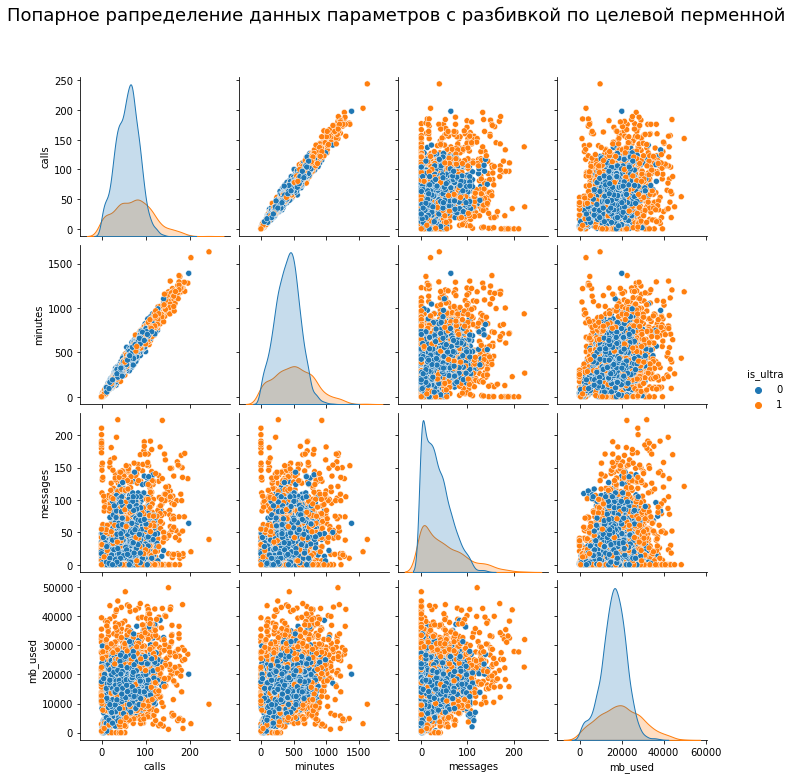

In [8]:
# проверяем попарное распределение данных в параметрах с разбивкой по целевой перменной
g = sns.pairplot(data=data, hue='is_ultra')
g.fig.suptitle('Попарное рапределение данных параметров с разбивкой по целевой перменной', y=1.08, fontsize=18);

**Выводы по данным и графикам:**
* данные не содержат аномальных значений
* плотность данных по всем параметроам выше у тарифа smart
* стандартное отклонение выше в тарфие ultra по всем параметрам
* параметры calls и minutes имеют выраженную линейную зависимость в обоих тарифах
* выбросы имеются в данных обоих тарифов
* 25% пользователей ultra имеют схожие показатели c пользователями тарифа smart в параметрах calls и minutes
* 25% пользователей ultra имеют более низкие показатели по сравнению c пользователями тарифа smart в параметрах messages и mb_used

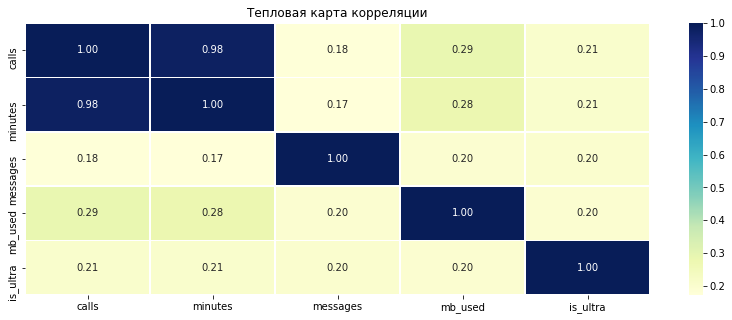

In [9]:
# строим тепловую карту корреляции
plt.figure(figsize=(14, 5)) 
heatmap = sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap="YlGnBu") 
heatmap.set_title('Тепловая карта корреляции', fontsize=12);

**Выводы по графику:**
* матрица корреляции показывает сильную положительную линейную зависимость между параметрами calls и minutes
* между остальными параметрами зависимость слабая положительная

## Разделение данных на выборки

In [10]:
# делим данные на признаки (матрица X) и целевую переменную (y)
# проверяем количество измерений 
X = data.drop('is_ultra', axis=1)
y = data['is_ultra']
print(X.shape)
print(y.shape)

(3214, 4)
(3214,)


In [11]:
# разделяем данные на обучающую и тестовую выборки в пропорции 60х40
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify = y, random_state=0
)

In [12]:
# проверяем количество измерений в выборках
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1928, 4)
(1928,)
(1286, 4)
(1286,)


In [13]:
# разделяем данные тестовой выборке на валидационную и тестовую выборки в пропорции 50х50
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, stratify = y_test, random_state=0
)

In [14]:
# проверяем количество измерений в выборках
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(643, 4)
(643,)
(643, 4)
(643,)


In [15]:
# проверяем равномерность распределения данных по классам в выборках
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
print(f"Количество строк в y_valid по классам: {np.bincount(y_valid)}")
print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [1337  591]
Количество строк в y_valid по классам: [446 197]
Количество строк в y_test по классам: [446 197]


In [16]:
# стандартизируем данные
# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий, валидационный и тестовый наборы данных
X_train_st = scaler.transform(X_train)
X_valid_st = scaler.transform(X_valid)
X_test_st = scaler.transform(X_test)

### Выводы

* датасет разделен матрицу признаков (X) и целевую переменную (y)
* данные разделены на обучающую, валидационную и тестовую выборки в пропорции 60х20х20
* равномерность распределения данных по классам в выборках соблюдена
* обучающий и тестовый наборы данных стандартизированы

## Исследование моделей

### Логистическая регрессия

In [17]:
# задаем алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0, solver='liblinear')

# обучаем модель
lr_model.fit(X_train_st, y_train)

# делаем прогноз на валидационной выборке
lr_predictions_valid = lr_model.predict(X_valid_st)
lr_probabilities_valid = lr_model.predict_proba(X_valid_st)[:, 1]

In [18]:
# выводим метрики для полученного прогноза по модели логистической регрессии
print('Метрики при автоматическом прогнозе на валидационной выборке по модели логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_valid, lr_predictions_valid)))
print('Precision: {:.2f}'.format(precision_score(y_valid, lr_predictions_valid)))
print('Recall: {:.2f}'.format(recall_score(y_valid, lr_predictions_valid)))

Метрики при автоматическом прогнозе на валидационной выборке по модели логистической регрессии
Accuracy: 0.76
Precision: 0.82
Recall: 0.28


### Дерево решений

In [19]:
# подбираем лучший гиперпараметр  max_depth с RandomizedSearchCV
max_depth = range(1, 13)
hyperparameters = dict(max_depth=max_depth)

DecisionTree = DecisionTreeClassifier(random_state=0)

randomizedsearch = RandomizedSearchCV(DecisionTree, hyperparameters)
dt_best_model_random = randomizedsearch.fit(X_train_st, y_train)
print(dt_best_model_random.best_estimator_)

DecisionTreeClassifier(max_depth=5, random_state=0)


In [20]:
# делаем прогноз с лучшей моделью
tr_model = DecisionTreeClassifier(random_state=0, max_depth=3)
tr_model.fit(X_train_st, y_train)
tr_predictions_valid = tr_model.predict(X_valid_st)

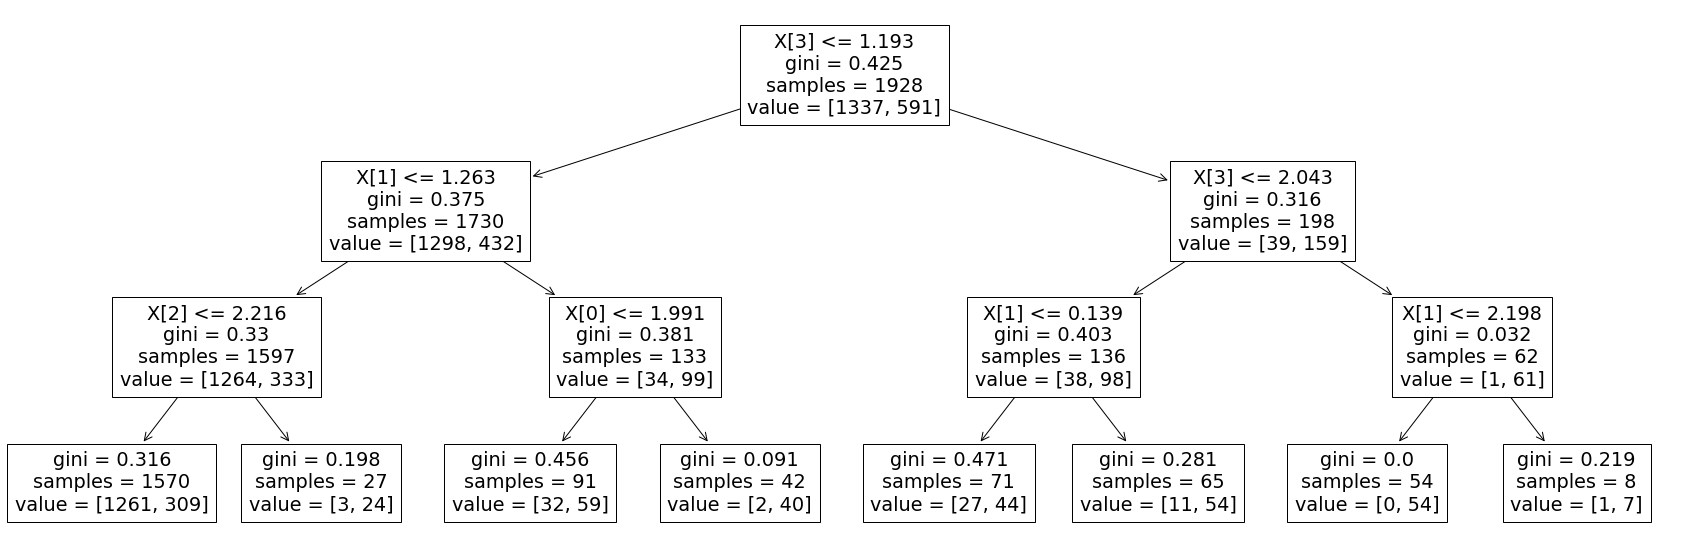

In [21]:
# Визуализируем логику решения выбранного дерева
fig, ax = plt.subplots(figsize=(30, 10))
tree.plot_tree(tr_model);

In [22]:
# выводим метрики для полученного прогноза по модели дерева решений
print('Метрики при автоматическом прогнозе на валидационной выборке по модели дерева решений')
print('Accuracy: {:.2f}'.format(accuracy_score(y_valid, tr_predictions_valid)))
print('Precision: {:.2f}'.format(precision_score(y_valid, tr_predictions_valid)))
print('Recall: {:.2f}'.format(recall_score(y_valid, tr_predictions_valid)))

Метрики при автоматическом прогнозе на валидационной выборке по модели дерева решений
Accuracy: 0.78
Precision: 0.69
Recall: 0.53


### Случайный лес

In [23]:
# подбираем лучший гиперпараметр  max_depth с RandomizedSearchCV
n_estimators = range(1, 100)
max_depth = range(1,13)
min_samples_leaf = range(1,13)

hyperparameters = dict( max_depth=max_depth, min_samples_leaf = min_samples_leaf, n_estimators = n_estimators,)

RandomForest = RandomForestClassifier(random_state = 0)

randomizedsearch = RandomizedSearchCV(RandomForest, hyperparameters)
rf_best_model_random = randomizedsearch.fit(X_train_st, y_train)
print(rf_best_model_random.best_estimator_)

RandomForestClassifier(max_depth=8, min_samples_leaf=4, n_estimators=55,
                       random_state=0)


In [24]:
# делаем прогноз с лучшей моделью
model = RandomForestClassifier(random_state=0, n_estimators=53, max_depth=7, min_samples_leaf = 8)
model.fit(X_train_st, y_train)
rf_predictions_valid = model.predict(X_valid_st)

In [25]:
# выводим метрики для полученного прогноза по модели случайного леса
print('Метрики при автоматическом прогнозе на валидационной выборке по модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_valid, rf_predictions_valid)))
print('Precision: {:.2f}'.format(precision_score(y_valid, rf_predictions_valid)))
print('Recall: {:.2f}'.format(recall_score(y_valid, rf_predictions_valid)))

Метрики при автоматическом прогнозе на валидационной выборке по модели случайного леса
Accuracy: 0.80
Precision: 0.73
Recall: 0.57


### Выводы
* для решения задачи классификации в ходе исследования были протестированы 3 модели на валидационной выборке:
>
> Логистическая регрессия
>
> Дерево решений
>
> Случайный лес
>
* **Логистическая регрессия** - показала на валидационной выборке следующие результаты по метрикам:
1. Accuracy: 0.76
2. Precision: 0.82
3. Recall: 0.28
* **Дерево решений** - проработан гиперпараметр глубины дерева; наилучший результат на валидационной выборке показала глубина =3 со следующими результатами по метрикам:
1. Accuracy: 0.78
2. Precision: 0.69
3. Recall: 0.53
* **Случайный лес** - проработаны гиперпараметры количества деревьев, глубины дерева и минимального количества выборок; наилучший результат на валидационной выборке показало количество деревьев = 53, глубины дерева = 7, количества выборок = 8 со следующими результатами по метрикам:
1. Accuracy: 0.80
2. Precision: 0.73
3. Recall: 0.57
* Так как целью работы модели является прогноз, на основе которого делается предложение клиенту тарифа *smart* или тарифа *ultra*, т.е. задача - максимально угадать предпочтение клиента на основе его поведения, целесообразно остановить выбор на модели **Случайного леса**, показавшей лучший результат по метрике **accuracy** (доля правильных ответов).

## Проверка модели на тестовой выборке

In [26]:
# обучаем модель случайного леса с количеством деревьев = 53 на тестовой выборке
rf_model_test = RandomForestClassifier(random_state=0, n_estimators=53, max_depth = 7, min_samples_leaf = 8)
rf_model_test.fit(X_train_st, y_train)

# делаем прогноз
rf_predictions_test = rf_model_test.predict(X_test_st)

In [27]:
# выводим метрики для полученного прогноза по модели случайного леса на тестовой выборке
print('Метрики при автоматическом прогнозе на тестовой выборке по модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions_test)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions_test)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions_test)))

Метрики при автоматическом прогнозе на тестовой выборке по модели случайного леса
Accuracy: 0.82
Precision: 0.81
Recall: 0.53


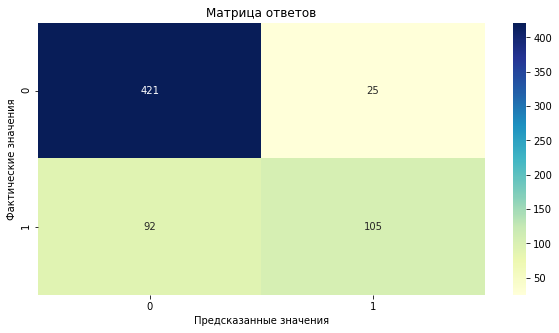

In [28]:
# выводим матрицу ответов
cm=confusion_matrix(y_test,rf_predictions_test)
plt.figure(figsize=(10,5))
plt.title('Матрица ответов')
sns.heatmap(cm, annot=True,fmt='d', cmap="YlGnBu")
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения');

### Выводы
* Модель RandomForestClassifier с подобранными гиперпараметрами:
>
> n_estimators=53
>
>, max_depth = 7
>
> min_samples_leaf = 8
>

показала на тестовой выборке следующие результаты по метрикам:
1. Accuracy: 0.82
2. Precision: 0.81
3. Recall: 0.53

## Проверка модели на адекватность

 Для проверки моделей на адекватность используем метрику **ROC_AUC**, отражающую точность вероятности прогноза.

In [29]:
# рассчитываем ROC_AUC для рассматривавшейся модели Логистической регрессии
lr_model_test = LogisticRegression(random_state=0, solver='liblinear')
lr_model_test.fit(X_train_st, y_train)
probabilities = lr_model_test.predict_proba(X_test)[:,1]
print('ROC_AUC_LogisticRegression: {:.2f}'.format(roc_auc_score(y_test, probabilities) ))

ROC_AUC_LogisticRegression: 0.50


In [30]:
# рассчитываем ROC_AUC для выбранной модели Дерева принятия решений
tr_model_test = DecisionTreeClassifier(random_state=0, max_depth=3)
tr_model_test.fit(X_train_st, y_train)
probabilities = tr_model_test.predict_proba(X_test)[:,1]
print('ROC_AUC_DecisionTree: {:.2f}'.format(roc_auc_score(y_test, probabilities) ))

ROC_AUC_DecisionTree: 0.53


In [31]:
# рассчитываем ROC_AUC для выбранной модели Случайного леса
probabilities = rf_model_test.predict_proba(X_test)[:,1]
print('ROC_AUC_Random_Forest: {:.2f}'.format(roc_auc_score(y_test, probabilities) ))

ROC_AUC_Random_Forest: 0.45


### Выводы
* Выбранная для оценки надежности, или адекватности модели метрика ROC_AUC показала, что все 3 рассматриваемые модели имеют достаточно низкий результат по данной метрике:
1. LogisticsRegression = 0.50
2. DecisionTreeClassifier = 0.53
3. RandomForestClassifier = 0.45

все 3 модели находятся на пороге 0.50, который характеризует результат предсказания моделей скорее как случайный.
* на поведение метрики влияют 2 ключевых фактора:
1. дисбаланс классов (70х30)
2. 25% данных, относящихся к рецессивному классу (тариф ultra), совпадают по всем признакам с доминантным классом (тариф smart)
* Рекомендуется к внедрению выбранная модель Случайного леса с фокусом на метрику accuracy, что позволит рекомендовать клиентам "корректный" вариант тарифа, основанный именно на их поведении.
* Лучшее соответствие предложения реальным потребностям (паттернам поведения) повысит лояльность клиентов.